<a href="https://colab.research.google.com/github/anthonymelson/portfolio/blob/master/Bayesian_Estimation_of_Difference_in_Success_Rate_Between_Two_Groups_on_Binary_Task_Using_Pymc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bayesian Estimation of Difference in Success Rate Between Two Groups on Binary Task Using Pymc3**

This notebook is meant to be a gentle intro to Bayesian Estimation.  The goal is *not* to claim that Bayesian Estimation is superior to frequentist hypothesis testing, but rather to highlight some of its appealing characteristics and show how it can be implemented in Pymc3.


### **Motivation**



Bayesian Estimation is used in many areas of science and industry and has been trending upwards in recent years.  When contrasted with frequentist approaches to estimating group differences (i.e. null hypothesis testing), benefits *can* include:
* clearer output (distribution of probabilities, instead of p-vals and confidence intervals)
* increased flexibility (small N, uneven groups, unequal var...)
* encoding/utilization of prior understanding (domain expertise, previous research...) into the prior distributions.
* ability to run online experiments (via belief updating) without concerns of p-hacking

This list is by no means comprehensive, but should provide those unfamiliar with Bayesian Estimation a sense of why it is worthy of investigation and usage in addition to null hypothesis testing.

## **Problem Discussion and Model Specification**

### **Problem Discussion**


**Problem**: A scientist is about to observe two groups (a and b) repeatedly flipping two *potentially* differently wieghted coins a *potentially* unequal number of times.  The scientist must design a test to: 1) decide whether the success rates (lands heads) of the two coins are equal, and if not 2) estimate the difference in thier likelihood of succeeding (landing heads).

**Goal**: Provide the testing framework to answer these questions and test it on synthetic data.

### **Model Specification**

In the following, a model will be specified as two Bernoulli distributsion (one for each arm of the experiment) with TruncatedNormal distributions as priors for their probability parameter (p).  Next, the posterior distributions (probability of probabilities of success) for each arm will be inferred using MCMC, and the difference between the two resultant distributions will be taken to get Delta_P (probability distribution of a range differences in probabilities of success between the two groups).

It should be noted that TruncatedNormal distributions were chosen as priors instead of the Beta distribution (which is the conjugate prior for the Bernoulli distribution) because they better represented the prior beliefs of the author in several ways:

>First, the author reasoned that even loaded coins are not likely to be *too* far from center since thier general shape (and the physics that govern that shape) would not allow for extreme bias.  Additional wieght (in the same direction) was given to the belief that coins that are too loaded or have the same symbol on each side wouldn't serve the function of deception that thier designers presumably intend them to serve.  The TruncatedNormal distribution's shape naturally encodes the increased likelihood of a loaded coin being closer to the center of the probability space (0.5) than to the edge of the probability space, near 1 or 0.

>Second, the author knows that almost all coins in the world are roughly fair and TruncatedNormal distributions allow that to be easily encoded (mu = 0.5) even when prior knowlegde about *specific coins*  is unavailable.

>Third, and more technically, it will cover the entire probability space (0-1), without going outside of it.  Since the Normal distribution is unbounded, it continues indefinately approaching 0 as it approaches infinity until it is bounded (truncation).


To capture the authors previously stated priors, the mean of the prior TruncatedNormal distributions will be set to 0.5 (second prior) and the standard deviation will be set to 0.15 (first prior), meaning the edges of the proability space (0,1) are several >3 standard deviations out from the mean.  Additionally, the lower and upper bounds will be set to 0 and 1, respectively (third prior).

## **Solution**

### **Import Packages**

In [ ]:
import arviz as az
import pymc3 as pm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
az.style.use("arviz-darkgrid")
from IPython.display import Markdown as md

### **Create Data**



In [ ]:
# Success probability for groups A and B
a_s, b_s = 0.6, 0.5

a = np.random.choice(a=[1,0],size=60,p=[a_s,1-a_s])
b = np.random.choice(a=[1,0],size=45,p=[b_s,1-b_s])

print('Observed Means: A:', a.mean(),'  B:', b.mean(), '  Delta:', abs(b.mean() - a.mean()))
print('True Means: A:', a_s,'  B:', b_s, '  Delta:', abs(b_s - a_s))

Observed Means: A: 0.5833333333333334   B: 0.4222222222222222   Delta: 0.16111111111111115
True Means: A: 0.6   B: 0.5   Delta: 0.09999999999999998


### **Model Initialization**



Below, the two TruncatedNormal distributions are parameterized with the previously selected mean and std.

Next, the Bernoulli Distributions are fit to the observed data and parameterized with the TruncatedNormal distributions for thier lone p parameter.

Then, a fifth distribution ('delta') is set as the difference between the two TruncatedNormal distribution, yeilding the difference in success probabilities of the two distributions.

Finally, the posterior distributions for the two TruncatedNormal distributions that inform the p parameter of the Bernoulli distribution are inferred using the NUTS algorithm (2000 samples, 4 chains).

In [ ]:
# convert input data to numpy arrays
a = np.asarray(a)
b = np.asarray(b)
with pm.Model() as model:

  # Create priors for bernoulli distributions
  mu_a, mu_b, sigma_a, sigma_b = 0.5, 0.5, 0.15, 0.15

  p_a = pm.TruncatedNormal('p_a', mu=mu_a, sigma=sigma_a, lower=0, upper=1)
  p_b = pm.TruncatedNormal('p_b', mu=mu_b, sigma=sigma_b, lower=0, upper=1)

  # Bernoulli random variables with priors AND observed data for both groups
  a_obs = pm.Bernoulli('a_obs', p=p_a, observed=a)
  b_obs = pm.Bernoulli('b_obs', p=p_b, observed=b)

  # Take difference between posteriors to get Delta_p
  delta = pm.Deterministic('delta', p_a - p_b)

  # Sample from the previously defined model
  trace = pm.sample(2000, chains=4, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [p_b, p_a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


In [ ]:
model.deterministics

[p_a ~ TruncatedNormal, p_b ~ TruncatedNormal, delta ~ Deterministic]

### **Inferences and Calculations from Model**

Now, the estimated posteriors are used to find the posterior delta, probability that group A has a higher success rate than group B, and the Bayes Factor (comparing H0 to H1, where they state the greater success rate of A and B, respectively).

In [ ]:
# Use sample to estimate posterior distributions for both experimental arms
a_posterior = trace.posterior['p_a'].values
b_posterior = trace.posterior['p_b'].values

# Use sample to estimate posterior distribution of delta
delta_posterior = trace.posterior['delta'].values

# Find probability that the success probability is higher in arm a than b
prob_a_over_b = (a_posterior[0] > b_posterior[0]).mean()

# Get Bayes Factor
bayes_factor = (a_posterior[0] > b_posterior[0]).mean() / (a_posterior[0] < b_posterior[0]).mean()


## **Results Summary and Visualization**

### **View as Bayesian Graphical Model**

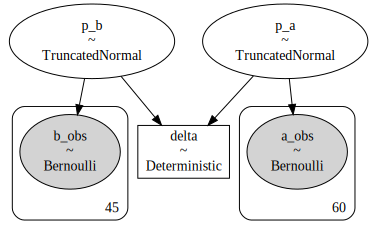

In [ ]:
pm.model_to_graphviz(model)

### **Summary of Model Variables & Probability of Difference**

Below, the mean, standard deviation, and credible intervals of the TruncatedNormal posteriors (for the parameters p in the two Bernoulli distributions) are shown along with the delta of the two (focus of the test).

Below that, the probability of a difference in success probabilities is shown for the cases where a > b and b > a.

Below that, the Bayes Factor is given.

In [ ]:
az.summary(trace, kind='stats')

,mean,sd,hdi_3%,hdi_97%
p_a,0.570,0.058,0.459,0.675
p_b,0.439,0.064,0.314,0.555
delta,0.131,0.086,-0.035,0.285


In [ ]:
print('Observed Means: A:', a.mean(),' B: ', b.mean(), 'Delta: ', abs(b.mean() - a.mean()))
print('True Means: A:', a_s,' B: ', b_s, 'Delta: ', abs(b_s - a_s))

Observed Means: A: 0.5833333333333334  B:  0.4222222222222222 Delta:  0.16111111111111115
True Means: A: 0.6  B:  0.5 Delta:  0.09999999999999998


In [ ]:
print('P(P_success(a) > P_success(b)): ', prob_a_over_b)
print('P(P_success(b) > P_success(a)): ', 1 - prob_a_over_b)

P(P_success(a) > P_success(b)):  0.946
P(P_success(b) > P_success(a)):  0.05400000000000005


In [ ]:
print('H0 = Group A has greater success rate than group B')
print('H1 = Group B has greater success rate than group A')
print('Bayes Factor: ',bayes_factor)

H0 = Group A has greater success rate than group B
H1 = Group B has greater success rate than group A
Bayes Factor:  17.51851851851852


### **View Posterior Distributions and Trace Plots**

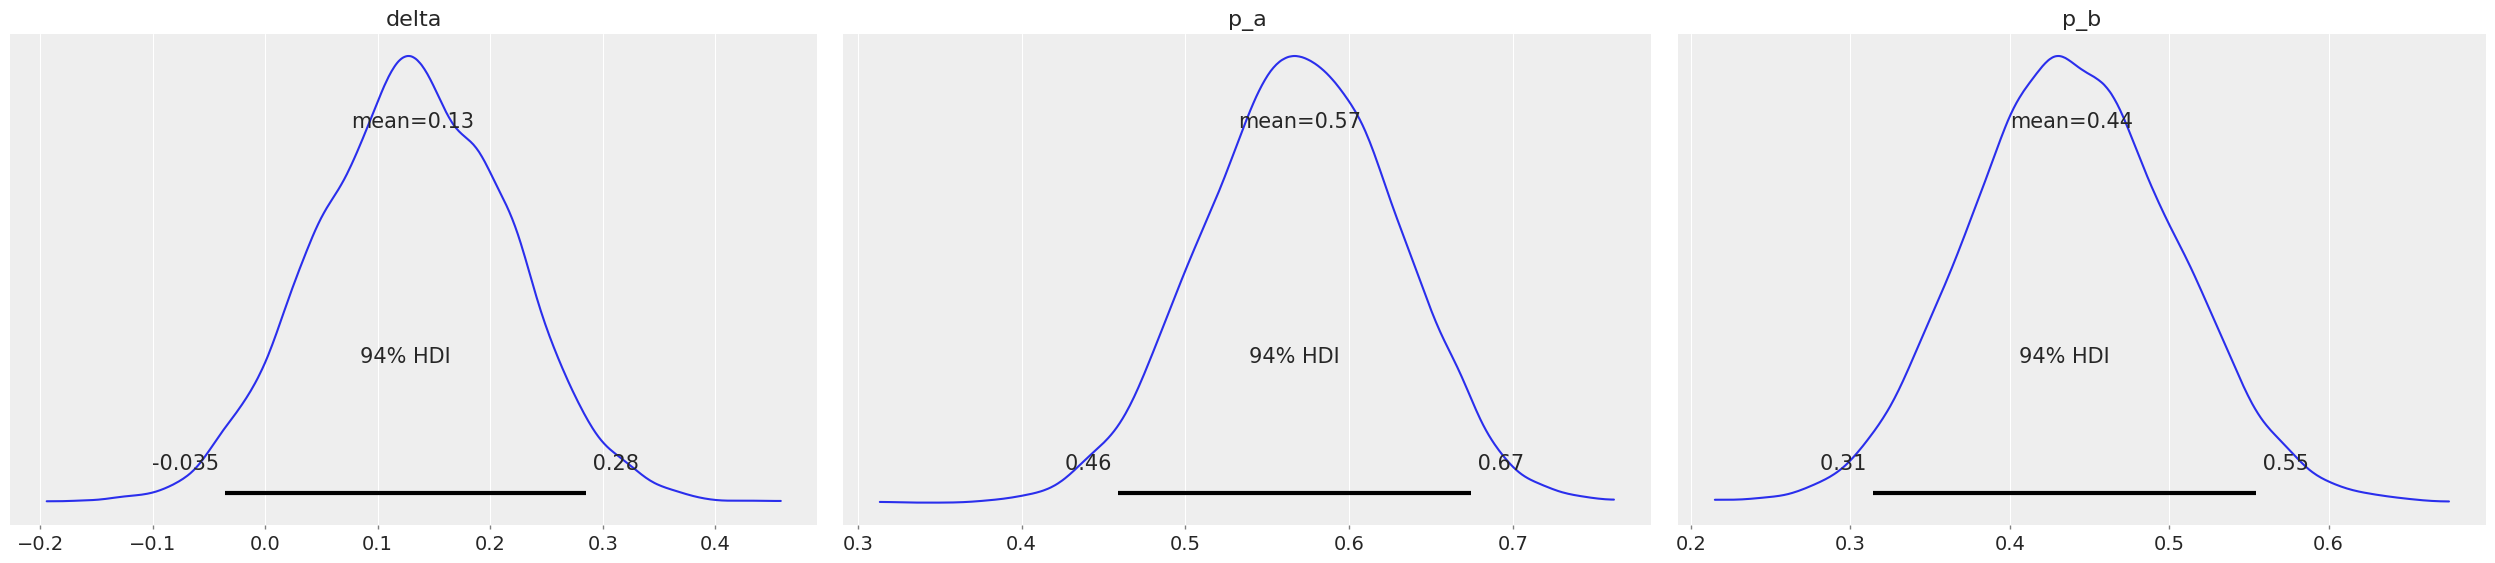

In [ ]:
az.plot_posterior(trace, ['delta', 'p_a', 'p_b'])
plt.show()

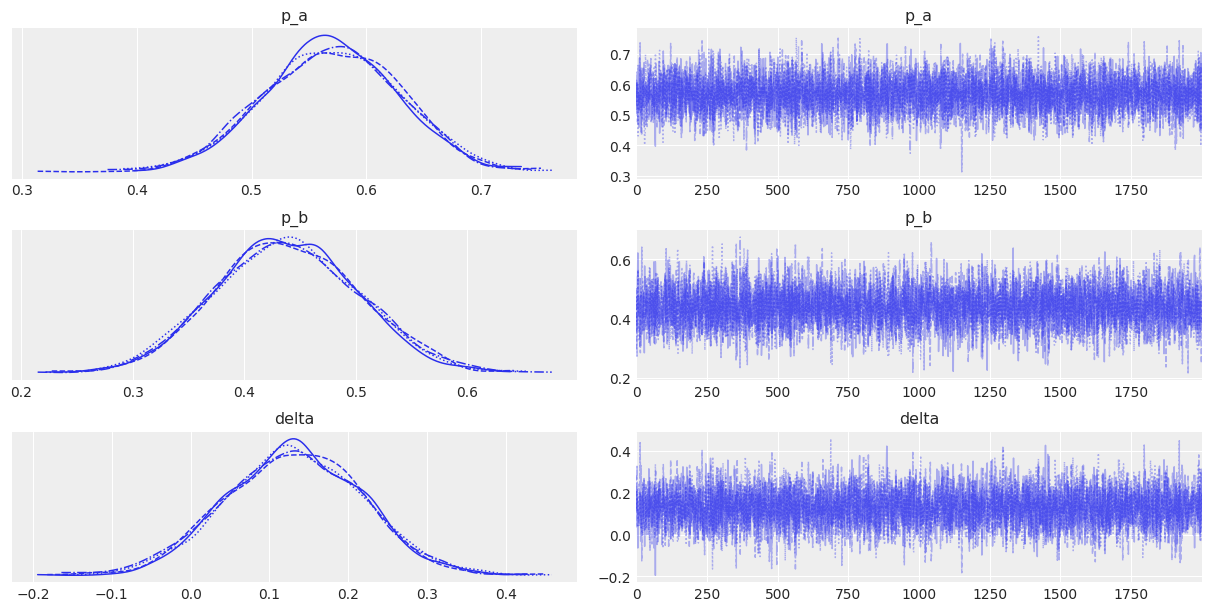

In [ ]:
az.plot_trace(trace)
plt.show()

### **A Second View of Posteriors (After Kernal Density Estimation)**

These visualizations better reveal the overlap and difference between the two posteriors.  Additionally, plotting the two together gives a clearer read of thier comparative variability, which is interpretable as certainty/reliability.

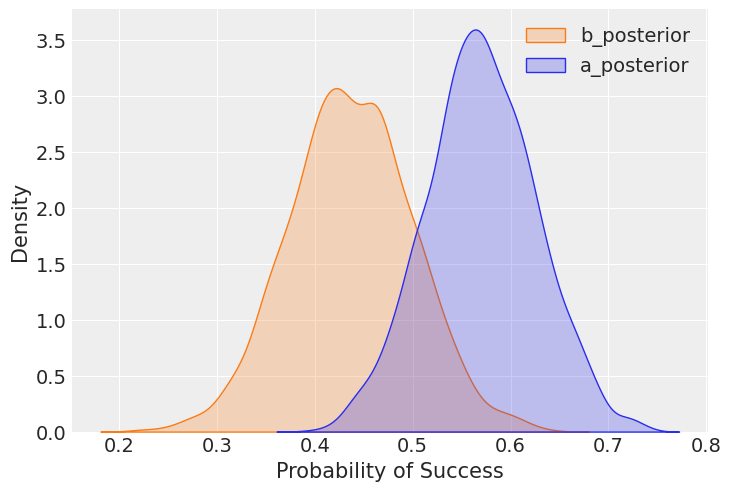

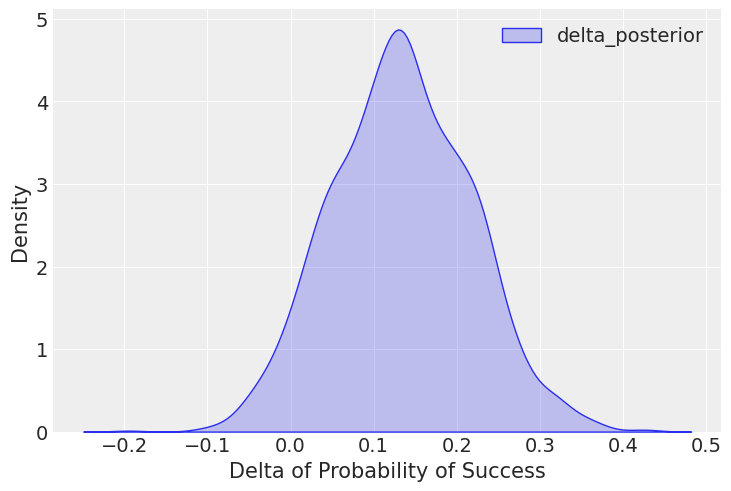

In [ ]:
kde = sns.kdeplot(data=[a_posterior[0],b_posterior[0]], fill=True)
kde.legend(labels=['b_posterior','a_posterior'])
plt.xlabel('Probability of Success')
plt.show()
delta_kde = sns.kdeplot(data=delta_posterior[0], fill=True)
delta_kde.legend(labels=['delta_posterior'])
plt.xlabel('Delta of Probability of Success')
plt.show()

## **Conclusion**


In [ ]:
#@title
delt = az.summary(trace, kind='stats')['mean']['delta']
pb = az.summary(trace, kind='stats')['mean']['p_b']
pa = az.summary(trace, kind='stats')['mean']['p_a']
ob = abs(b.mean()-a.mean())

md(f'The fitted model determined that there is a {prob_a_over_b} probability that Group A has a higher success rate (bayes factor = {bayes_factor}) than Group B, compared with their true wieghts of {pa} and {pb} respectively.  The predicted delta was {delt}, compared to that of the data generating process (0.1) and the observed data ({ob}).  These two outputs give answers to the two questions our framework was designed to answer.  Success!')

The fitted model determined that there is a 0.946 probability that Group A has a higher success rate (bayes factor = 17.51851851851852) than Group B, compared with their true wieghts of 0.57 and 0.439 respectively.  The predicted delta was 0.131, compared to that of the data generating process (0.1) and the observed data (0.16111111111111115).  These two outputs give answers to the two questions our framework was designed to answer.  Success!

## Appendix 1 -- Likelihood that Delta_p > Selected Value

Finding the probability that the difference in success rates is above a certain threshold or within a certain range has enumberable applications is business.  Additionally, it reveals the increased flexibility/utility of Bayesian Estimation in over to Frequentist hypothesis testing.

The function below is defined to take a posterior distribution (of probabilities), an upper bound, and a lower bound as inputs and return the probability of the probability being within that range.  It is initialized with lb = -1 and ub = 1 since they are the the upper and lower bounds of a distribution of probability differences (our interest).

In [ ]:
def p_greater_x(p_posterior_dist, lb=-1, ub=1):
  return ((lb < p_posterior_dist) & (p_posterior_dist < ub)).sum() / len(p_posterior_dist)

### Example 1

Imagine that we tested our two groups to determine which would provide us a higher success rate, but there are different costs associated with the two options.  We know that option A must succeed at least 5% more often than option B for it to be the correct decision.  We can test that with our posterior delta_p.

We find that there is an 82.95% chance it is *at least* that much better, which gives us the green light on option A!

In [ ]:
p_greater_x(p_posterior_dist=delta_posterior[0], lb=0.05, ub=1)

0.8295